In [ ]:
#!wget http://dtn-max.ifa.hawaii.edu/SpaceApps/2024/spaceappschallenge_seismicdetection_data.zip
#!wget http://dtn-itc.ifa.hawaii.edu/spaceapps/2024/spaceappschallenge_seismicdetection_data.zip

In [ ]:
#!unzip spaceappschallenge_seismicdetection_data.zip

In [ ]:
#%cd /content
#!ls

In [ ]:
#Install prerequisite packages
#%pip install obspy

In [1]:
#Import modules
import numpy as np
import pandas as pd
import scipy
from scipy.signal import hilbert,find_peaks
from scipy.interpolate import UnivariateSpline
import obspy
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
import typing
from typing import *
%matplotlib inline

In [2]:
#GLOBAL VARIABLES
DATASET_ROOT_PATH="data"

In [3]:
#Dataset
'''
class to assimilate data ,
Input: paths to dataset
Output: Multi-dim matrix,  np.ndarray or torch.tensor
'''
class SeismicDataset:

  def __init__(self,dataset_root:str)->None:
    self.dataset_root=dataset_root
    self.list_of_planets=["lunar","mars"]
    self.modes=["train","test"]

  def loadDataset(self)->np.ndarray:
      '''
      dataset of shape (Number of samples, timestamps)
      '''
      signal_stack=[]
      labels=[]
      sampling_rate=[]

      for i,row in self.dataset.iterrows():
        filename=row["filename"]
        time_rel=row["time_rel(sec)"]
        signal = obspy.read(filename + ".mseed")
        signal_stack.append(signal[0].data)
        labels.append(time_rel)
        sampling_rate.append(signal[0].stats.sampling_rate)
        print(filename,time_rel)
      return signal_stack, labels, sampling_rate

  def generatePathToLogs(self)->None:
    '''
    returns a DataFrame with columns: filename,logname,time_rel(label)
    '''
    # Extract Catalog for time_rel aka label data
    database_roots={"catalog":
                    {"lunar":
                    {"train":"lunar/catalog"},
                    "mars":
                    {"train":"mars/catalog"}
                    }
                  }
    list_of_csvs_path=[]
    for planet_data in database_roots.values():
      for planet,data_cap in planet_data.items():
        for data_category,path in data_cap.items():
          path1=os.path.join(self.dataset_root,path)
          list_dirs=os.listdir(path1)
          for csvpath in list_dirs:
              path2=os.path.join(path1,csvpath)
              assert os.path.isfile(path2), "Path not found"
              list_of_csvs_path.append(path2)

    catalog=[]

    for csv_path in list_of_csvs_path:
      df=pd.read_csv(csv_path)
      df["logname"]=df["filename"].apply(lambda name: name.strip(".csv").strip(".mseed"))

      df.name="_".join(csv_path.split("/")[1:3])
      catalog.append(df)
    lunar_catalog=catalog[0]
    mars_catalog=pd.merge(catalog[1],catalog[2])
    #Extract signal data

    database_roots={"data":
                  {"lunar":
                  {"train":"lunar/train",
                  "test":"lunar/test"},
                  "mars":
                  {"train":"mars/train",
                  "test":"mars/test"}
                  }
                }
    list_of_csvs=[]

    for planet_data in database_roots.values():
        for planet,data_cap in planet_data.items():
            for data_category,path in data_cap.items():
                path1=os.path.join(self.dataset_root,path)
                scandir=os.scandir(path1)
                respaths=[]
                lognames=[]
                for sample in scandir:

                  res_path=os.path.join(path1,sample.name.strip(".csv").strip(".mseed"))
                  log_name=sample.name.strip(".csv").strip(".mseed")
                  respaths.append(res_path)
                  lognames.append(log_name)

                df=pd.DataFrame({"filename":respaths,"logname":lognames})
                df.attrs["metadata"]={"name":planet,"type":data_category}
                list_of_csvs.append(df)
                del df

    lunar_train_signals_table=list_of_csvs[0]
    lunar_test_signals_table=list_of_csvs[1]
    mars_train_signals_table=list_of_csvs[2]
    mars_test_signals_table=list_of_csvs[3]
    # Perform an inner join with logname to get a dataframe
    lunar_training_data=pd.merge(lunar_train_signals_table,lunar_catalog, on='logname')
    lunar_training_data=lunar_training_data.drop(columns=["filename_y"])
    lunar_training_data=lunar_training_data.rename(columns={"filename_x":"filename"})

    self.dataset=lunar_training_data


'''
Test block
'''
dataTester=SeismicDataset(DATASET_ROOT_PATH)
dataTester.generatePathToLogs()
train_data,train_labels,sampling_rate=dataTester.loadDataset()

data/lunar/train/xa.s12.00.mhz.1971-04-17HR00_evid00030 25440.0
data/lunar/train/xa.s12.00.mhz.1973-08-21HR00_evid00127 44220.0
data/lunar/train/xa.s12.00.mhz.1973-07-04HR00_evid00114 9960.0
data/lunar/train/xa.s12.00.mhz.1975-05-04HR00_evid00192 36300.0
data/lunar/train/xa.s12.00.mhz.1973-01-18HR00_evid00088 82860.0
data/lunar/train/xa.s12.00.mhz.1974-06-25HR00_evid00149 1380.0
data/lunar/train/xa.s12.00.mhz.1971-05-13HR00_evid00033 10800.0
data/lunar/train/xa.s12.00.mhz.1974-04-26HR00_evid00144 33480.0
data/lunar/train/xa.s12.00.mhz.1971-01-28HR00_evid00023 53940.0
data/lunar/train/xa.s12.00.mhz.1973-03-01HR00_evid00093 26100.0
data/lunar/train/xa.s12.00.mhz.1970-07-20HR00_evid00011 42240.0
data/lunar/train/xa.s12.00.mhz.1974-07-17HR00_evid00153 43500.0
data/lunar/train/xa.s12.00.mhz.1972-07-31HR00_evid00071 65280.0
data/lunar/train/xa.s12.00.mhz.1973-07-28HR00_evid00120 3120.0
data/lunar/train/xa.s12.00.mhz.1972-07-17HR00_evid00067 28200.0
data/lunar/train/xa.s12.00.mhz.1974-04-08HR

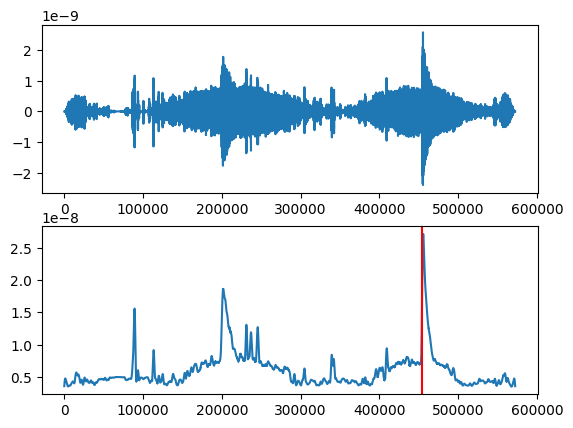

filename                          data/lunar/train/xa.s12.00.mhz.1973-07-20HR00_...
logname                                      xa.s12.00.mhz.1973-07-20HR00_evid00117
time_abs(%Y-%m-%dT%H:%M:%S.%f)                           1973-07-20T19:02:00.000000
time_rel(sec)                                                               68520.0
evid                                                                      evid00117
mq_type                                                                     deep_mq
Name: 52, dtype: object


In [4]:
#PreProcessing
'''
Input:Signal
Output: Transformed / Augmented data
'''
class ProcessSignal:
  def __init__(self)->None:
    pass
  def detectEnvelope(self,x:np.ndarray,N:int,method = 'analytic', window="hamming"):

    x=np.abs(x)
    #Assert that x is a 1D numpy array
    kernel_mapper={"rect":np.ones(N)/N,"hamming":np.hamming(N),"hanning":np.hanning(N),"blackman":np.blackman(N),
                  "gaussian":scipy.signal.windows.gaussian(N,1),"tukey":scipy.signal.windows.tukey(N,1)}
    if method == 'analytic':

      #Calculate the mean of x and remove it
      x_mean = np.mean(x)
      x_zero_mean = x-x_mean

      #Take the absolute value of the Hilbert transform
      #to calculate the analytical envelope of the zero mean
      #version of x
      zero_mean_envelope = np.abs(hilbert(x_zero_mean,N = N))

      #Calculate and return upper and lower envelopes
      return x_mean+zero_mean_envelope,x_mean-zero_mean_envelope

    elif method == 'rms':

      #Assert that N is specified and is an integer
      #For the rms method N serves as window size
      #for the moving average
      assert N and isinstance(N,int), 'N must be an integer'

      #Calculate the mean of x and remove it
      x_mean = np.mean(x)
      x_zero_mean = x-x_mean
      #Moving average is calculated using np.convolve


      #Calculate the RMS envelope of the zero mean version of x.
      kernel=kernel_mapper[window]
      #Moving average is calculated using np.convolve
      zero_mean_envelope = np.sqrt(np.convolve(x_zero_mean**2,kernel,mode = 'same'))

      #Calculate and return upper and lower envelopes
      return x_mean+zero_mean_envelope,x_mean-zero_mean_envelope

    elif method == 'peak':

      #Assert that N is specified and is an integer
      #For the peak method N serves as the minimum number of
      #samples that seperate local maxima
      assert N and isinstance(N,int), 'N must be an integer'

      #Calculate local maxima and minima which will serve
      #as peaks for upper and lower envelopes respectively
      peaks_upper,_ = find_peaks(x,distance = N)
      peaks_lower,_ = find_peaks(-x,distance = N)

      #Calculate upper and lower envelopes by interpolating
      #peaks using a Univariate spline
      upper_spline = UnivariateSpline(peaks_upper,x[peaks_upper])
      lower_spline = UnivariateSpline(peaks_lower,x[peaks_lower])
      upper_envelope = upper_spline(np.arange(x.shape[0]))
      lower_envelope = lower_spline(np.arange(x.shape[0]))

      #Return the envelopes
      return upper_envelope,lower_envelope

    else:

      raise ValueError('%s is not a valid method' %(method))

  def compareSignals(self,original:np.ndarray,signal:np.ndarray,fs:float,arrival_time:float,block:Optional[bool]=True)->None:

    plt.close()
    plt.subplot(2,1,1)
    plt.plot(original)
    plt.subplot(2,1,2)
    plt.plot(signal)
    plt.axvline(x=(arrival_time*fs),color="red")
    plt.show()
  '''
  Test block
  '''
idx=52
x_input,x_label,fs=train_data[idx],train_labels[idx],sampling_rate[idx]
p=ProcessSignal()
envelope=p.detectEnvelope(x_input,int(fs*512),'rms',"hamming")
p.compareSignals(x_input,envelope[0],fs,x_label)
print(dataTester.dataset.iloc[idx])

In [5]:
# SeismicModel and dependencies

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse, binary_crossentropy, KLDivergence
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K

from SeismicModel import SeismicModel

2024-10-06 04:45:41.559378: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-06 04:45:41.559430: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-06 04:45:41.560765: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-06 04:45:41.567448: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
# Model Definition
'''
Define model architectures
Input: tensor signal
Output: binary signal
'''
min_len = 1e6
N = len(train_data[:])
for idx in range(N):
    if train_data[idx].shape[0] < min_len:
        min_len = train_data[idx].shape[0]

x = np.zeros((N,min_len))
for idx in range(len(train_data[:])):
    x[idx] = train_data[idx][:min_len]
print(x.shape)

seismic_model = SeismicModel(name="vae-mlp")
seismic_model.SetTrain(x, x)
seismic_model.BuildModel()

(75, 342378)
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 342378)]             0         []                            
                                                                                                  
 dense (Dense)               (None, 64)                   2191225   ['encoder_input[0][0]']       
                                                          6                                       
                                                                                                  
 dense_1 (Dense)             (None, 32)                   2080      ['dense[0][0]']               
                                                                                                  
 z_mean (Dense)              (None, 16)                   528       ['dense_1[0

In [7]:
# Model Training
'''
Compile the model (Define optimizers, hyperparams, etc.)
Start/end Training
Store model checkpoints
Plot training and validation loss
'''

seismic_model.Compile(lr=3e-5)


Model: "vae-mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 342378)]          0         
                                                                 
 encoder (Functional)        (None, 16)                21915392  
                                                                 
 decoder (Functional)        (None, 342378)            22257226  
                                                                 
Total params: 44172618 (168.51 MB)
Trainable params: 44172618 (168.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2024-10-06 04:45:46.801839: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-10-06 04:45:46.801869: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: nvgpu
2024-10-06 04:45:46.801877: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: nvgpu
2024-10-06 04:45:46.801979: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 550.90.7
2024-10-06 04:45:46.801998: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 550.90.7
2024-10-06 04:45:46.802005: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 550.90.7


In [8]:
history = seismic_model.Train()

2024-10-06 04:45:56.511336: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-10-06 04:45:56.981253: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_4/bias/Assign' id:192 op device:{requested: '', assigned: ''} def:{{{node dense_4/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_4/bias, dense_4/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-10-06 04:46:17.279526: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: type mismatch for node 'DatasetToGraphV2': expected a subtype of:
type_id: TFT_PRODUCT
args {
  type_id: TFT_ENCODED
  args {
    type_

Train on 10 steps
Epoch 1/10


2024-10-06 04:46:25.831394: W tensorflow/c/c_api.cc:305] Operation '{name:'loss/mul' id:294 op device:{requested: '', assigned: ''} def:{{{node loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul/x, loss/decoder_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-10-06 04:46:26.675021: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_3/bias/v/Assign' id:668 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_3/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_3/bias/v, training/Adam/dense_3/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't

10/10 [==============================] - 4s 148ms/step - batch: 4.5000 - size: 1.0000 - loss: 555148.2109
Epoch 2/10
10/10 [==============================] - 2s 145ms/step - batch: 4.5000 - size: 1.0000 - loss: 371108.5656
Epoch 3/10
10/10 [==============================] - 2s 150ms/step - batch: 4.5000 - size: 1.0000 - loss: 228043.3016
Epoch 4/10
10/10 [==============================] - 2s 149ms/step - batch: 4.5000 - size: 1.0000 - loss: 134619.5973
Epoch 5/10
10/10 [==============================] - 1s 147ms/step - batch: 4.5000 - size: 1.0000 - loss: 79967.1764
Epoch 6/10
10/10 [==============================] - 2s 149ms/step - batch: 4.5000 - size: 1.0000 - loss: 46508.2670
Epoch 7/10
10/10 [==============================] - 2s 149ms/step - batch: 4.5000 - size: 1.0000 - loss: 30950.5855
Epoch 8/10
10/10 [==============================] - 2s 150ms/step - batch: 4.5000 - size: 1.0000 - loss: 20804.0410
Epoch 9/10
10/10 [==============================] - 2s 148ms/step - batch: 4.50

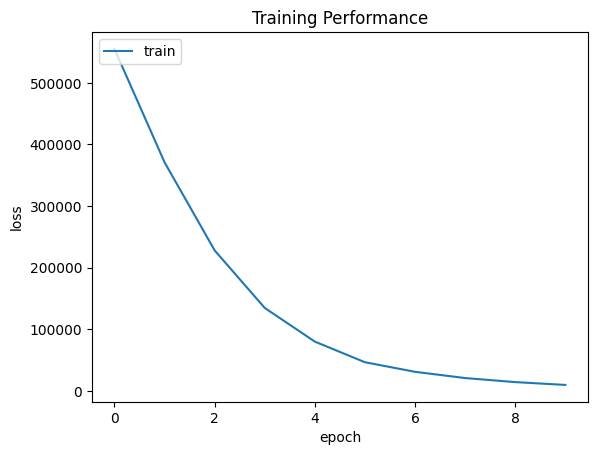

In [12]:
plt.plot(history.history['loss'])
#plt.plot(history.history['loss'])
plt.title('Training Performance')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train', 'val'], loc='upper left')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
#Evaluation
'''
Input: Model, test data
Output: pd.Dataframe or similar table with evaluation results
'''

In [ ]:
#Demo app
'''
Input: Model, sample input signal
'''